In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, mean_absolute_error
from skimage.metrics import structural_similarity as ssim

In [2]:
class LandscapeColorizationDataset(Dataset):
    def __init__(self, gray_dir, color_dir):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.gray_images = sorted(os.listdir(gray_dir))
        self.color_images = sorted(os.listdir(color_dir))

    def __len__(self):
        return len(self.gray_images)

    def __getitem__(self, idx):
        gray_path = os.path.join(self.gray_dir, self.gray_images[idx])
        color_path = os.path.join(self.color_dir, self.color_images[idx])

        gray = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)
        color = cv2.imread(color_path)
        color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)

        gray = cv2.resize(gray, (128, 128))
        color = cv2.resize(color, (128, 128))

        gray = torch.from_numpy(gray).float().unsqueeze(0) / 255.0
        color = torch.from_numpy(color).float().permute(2, 0, 1) / 255.0

        return gray, color

In [3]:
class ColonizationNet(nn.Module):
    def __init__(self):
        super(ColonizationNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
gray_path = "/kaggle/input/landscape-image-colorization/landscape Images/gray"
color_path = "/kaggle/input/landscape-image-colorization/landscape Images/color"
  
full_dataset = LandscapeColorizationDataset(gray_path, color_path)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColonizationNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

for epoch in range(20):
    model.train()
    running_loss = 0
    for gray, color in train_loader:
        gray, color = gray.to(device), color.to(device)
        output = model(gray)
        loss = criterion(output, color)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/20], Loss: {running_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "/kaggle/working/colorization_model.pth")

Epoch [1/20], Loss: 0.0089
Epoch [2/20], Loss: 0.0073
Epoch [3/20], Loss: 0.0071
Epoch [4/20], Loss: 0.0069
Epoch [5/20], Loss: 0.0068
Epoch [6/20], Loss: 0.0069
Epoch [7/20], Loss: 0.0068
Epoch [8/20], Loss: 0.0067
Epoch [9/20], Loss: 0.0065
Epoch [10/20], Loss: 0.0065
Epoch [11/20], Loss: 0.0064
Epoch [12/20], Loss: 0.0063
Epoch [13/20], Loss: 0.0063
Epoch [14/20], Loss: 0.0063
Epoch [15/20], Loss: 0.0061
Epoch [16/20], Loss: 0.0060
Epoch [17/20], Loss: 0.0061
Epoch [18/20], Loss: 0.0059
Epoch [19/20], Loss: 0.0059
Epoch [20/20], Loss: 0.0059


In [6]:
def psnr(pred, target):
    mse = F.mse_loss(pred, target)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def colorization_accuracy(pred, target, threshold=0.07):
    diff = torch.abs(pred - target)
    correct = (diff < threshold).float()
    return correct.mean() * 100

def binarize(img, threshold=0.5):
    return (img > threshold).astype(np.uint8).flatten()

In [11]:
def evaluate(model, dataloader):
    model.eval()
    total_psnr, total_ssim, total_mae, total_acc = 0, 0, 0, 0
    y_true_flat, y_pred_flat = [], []
    with torch.no_grad():
        for gray, color in dataloader:
            gray, color = gray.to(device), color.to(device)
            output = model(gray)
            for i in range(gray.size(0)):
                out_img = output[i].cpu()
                tgt_img = color[i].cpu()
                out_np = out_img.permute(1, 2, 0).numpy()
                tgt_np = tgt_img.permute(1, 2, 0).numpy()

                total_psnr += psnr(out_img, tgt_img).item()
                total_ssim += ssim(out_np, tgt_np, channel_axis=2, data_range=1.0)
                total_mae += mean_absolute_error(tgt_np.flatten(), out_np.flatten())
                total_acc += colorization_accuracy(out_img, tgt_img).item()

                y_pred_flat.extend((out_np.flatten() > 0.5).astype(int))
                y_true_flat.extend((tgt_np.flatten() > 0.5).astype(int))

    n = len(dataloader.dataset)
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)

    print(f"\nAvg PSNR: {total_psnr/n:.2f} dB")
    print(f"Avg SSIM: {total_ssim/n:.4f}")
    print(f"Avg MAE : {total_mae/n:.6f}")
    print(f"Avg Pixel Accuracy: {total_acc/n:.2f}%")

    print("\nConfusion Matrix:")
    print(cm)
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}\n")

In [12]:
evaluate(model, val_loader)



Avg PSNR: 24.37 dB
Avg SSIM: 0.9235
Avg MAE : 0.047922
Avg Pixel Accuracy: 77.68%

Confusion Matrix:
[[39609060  1959275]
 [ 2514835 26007582]]
Precision: 0.9299
Recall: 0.9118



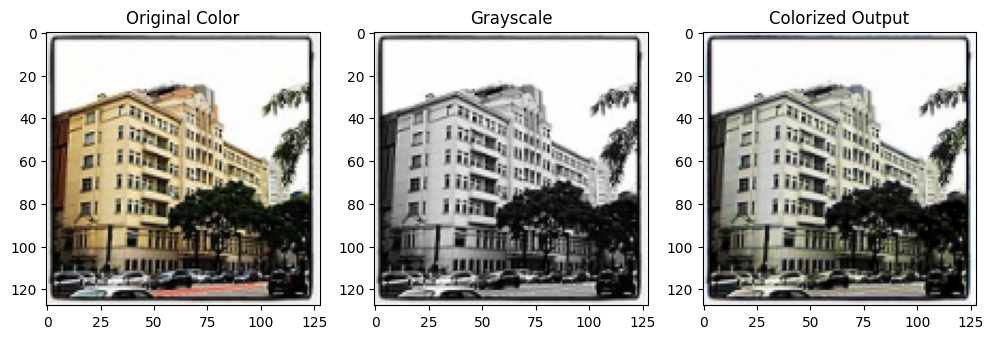

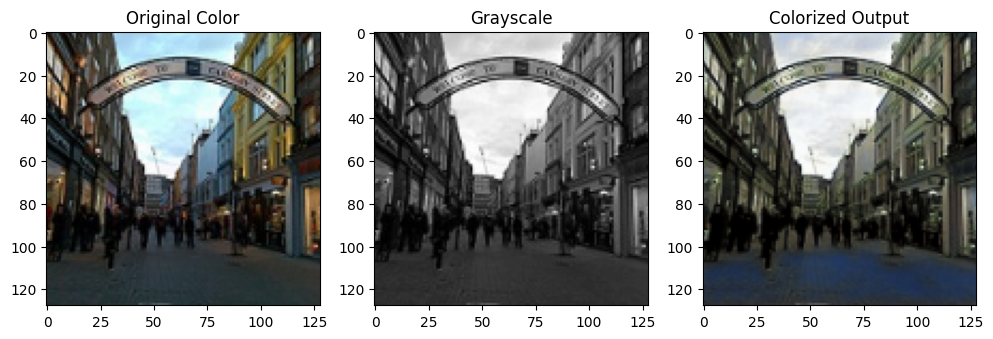

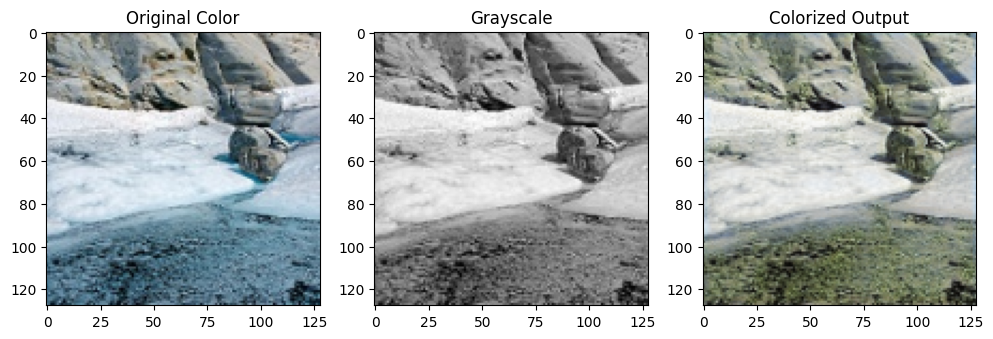

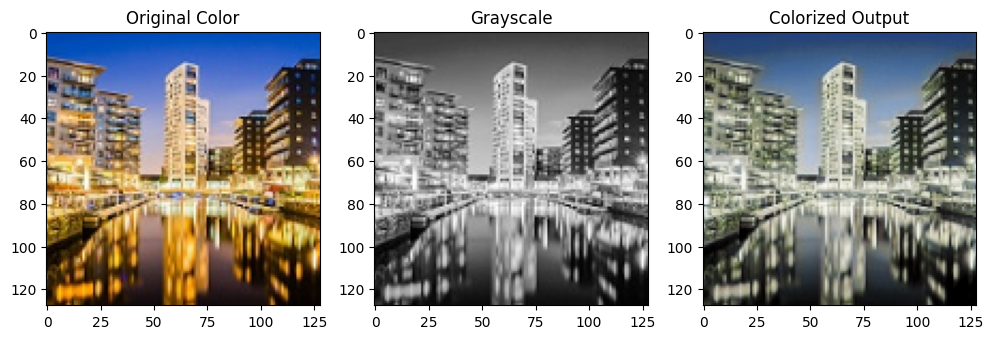

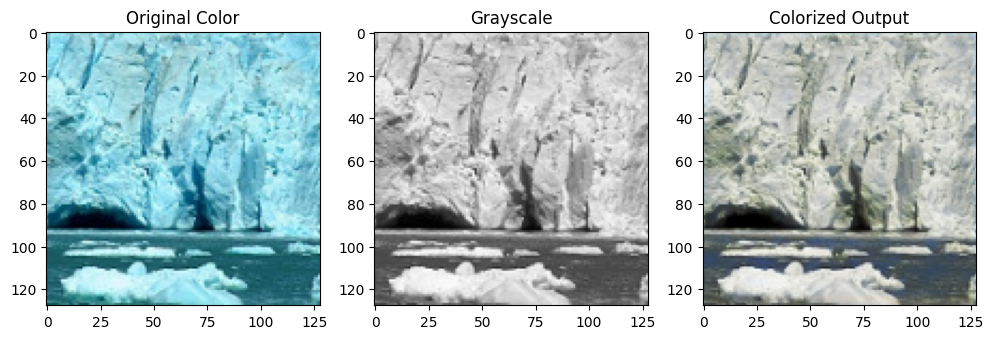

In [14]:
model.eval()
for i in range(5):
    gray, color = val_dataset[i]
    gray = gray.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(gray).cpu().squeeze(0)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(color.permute(1, 2, 0))
    axs[0].set_title("Original Color")
    axs[1].imshow(gray.cpu().squeeze(), cmap='gray')
    axs[1].set_title("Grayscale")
    axs[2].imshow(output.permute(1, 2, 0).numpy())
    axs[2].set_title("Colorized Output")
    plt.savefig(f"/kaggle/working/result_{i}.png")
    plt.show()